# Objective

In [1]:
# CNNs w SIFT instead of pooling: 
# https://arxiv.org/ftp/arxiv/papers/1904/1904.00197.pdf

# SIFT Descriptor implementation in PyTorch:
# https://github.com/ducha-aiki/pytorch-sift

#### Google Colab Helpers

In [2]:
# from google.colab import drive
# drive.mount("/content/gdrive")
# # drive.mount("/content/gdrive", force_remount=True)

In [3]:
# import os
# os.chdir("/content/gdrive/My Drive/...pathtocode")

In [4]:
# import torch
# a = torch.Tensor([1]).cuda()
# print(a)

## Load Fashion-MNIST and Net

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import copy

In [6]:
from utils.data_process import get_FASHION_data

TRAIN_IMAGES = 50000
VAL_IMAGES = 10000
TEST_IMAGES = 10000

data = get_FASHION_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots


# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [7]:
# from models.neural_net_simple import NeuralNet

# from models.neural_net_traditional import NeuralNet
from models.neural_net_sift import NeuralNet

## Init Net and Train

In [8]:
# Hyperparameters
input_size = 28 * 28
num_classes = 10
epochs = 40 # 10 # 2 # 40 # 15 # 5
batch_size = 200
learning_rate = 0.001

# Initialize a new neural network model
net = NeuralNet(learning_rate,input_size,num_classes)


# # extract output of layers
# https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/3
# https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
    
activation = {}
def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()
    return hook

# net.layers[2].register_forward_hook(get_activation('pre_fc')) # for net_simple

net.layers[3].register_forward_hook(get_activation('pre_fc')) # for net_trad
# net.layers[3].register_forward_hook(get_activation('pre_fc')) # for net_sift


In [9]:
TRAIN_IMAGES = 50000
VAL_IMAGES = 10000
TEST_IMAGES = 10000

data = get_FASHION_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# X_val = torch.tensor(X_val, dtype=torch.float32)
# y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)


# Variables to store performance for each epoch
train_loss = np.zeros(epochs)
train_accuracy = np.zeros(epochs)
val_accuracy = np.zeros(epochs)

start_time = time.time()
print('Running ',epochs,' epochs')

for epoch in range(epochs):
    print('Curr Time:',time.time()-start_time)    
    print('epoch:', epoch)

    # Shuffle the dataset
    # data[['X','y']].sample(frac = 1)
    perm = np.random.permutation(X_train.shape[0])
    np.take(X_train,perm,axis=0,out=X_train)
    np.take(y_train,perm,axis=0,out=y_train)
    
    # Training
    # For each mini-batch...
    for batch in range(TRAIN_IMAGES // batch_size):
#         if batch%10==0: print('batch_num:',batch)
        # Create a mini-batch of training data and labels
        X_batch = X_train[batch*batch_size : batch*batch_size + batch_size, :]
        y_batch = y_train[batch*batch_size : batch*batch_size + batch_size]
        
        X_batch = torch.tensor(X_batch, dtype=torch.float32)
        y_batch = torch.tensor(y_batch, dtype=torch.float32)

        # Run the forward pass of the model to get a prediction and compute the accuracy
        forward_out = net.forward(X_batch).detach().numpy()
        pred_labels = np.argmax(forward_out,axis=1)
        train_accuracy[epoch] += sum(pred_labels == np.asarray(y_batch)) / batch_size

        # Run the backward pass of the model to compute the loss, and update the weights
        y_batch_for_L = y_batch.type(torch.LongTensor)
        loss = net.backward(X_batch,y_batch_for_L)
        train_loss[epoch] += loss

    # normalize
    train_accuracy[epoch] /= (TRAIN_IMAGES // batch_size)
    train_loss[epoch] /= (TRAIN_IMAGES // batch_size)

    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    X_val = torch.tensor(X_val, dtype=torch.float32)
    val_forward_out = net.forward(X_val).detach().numpy()
    val_pred_labels = np.argmax(val_forward_out,axis=1)
    val_accuracy[epoch] += sum(val_pred_labels == np.asarray(y_val)) / len(y_val)
        

print('Done. Time:',time.time()-start_time)

Running  40  epochs
Curr Time: 0.0006048679351806641
epoch: 0
Curr Time: 32.1670880317688
epoch: 1


<ipython-input-9-ac3caf2e224a>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)


Curr Time: 67.20513606071472
epoch: 2
Curr Time: 106.80366110801697
epoch: 3
Curr Time: 144.50802612304688
epoch: 4
Curr Time: 182.98206090927124
epoch: 5
Curr Time: 217.80636143684387
epoch: 6
Curr Time: 253.46614360809326
epoch: 7
Curr Time: 286.53165769577026
epoch: 8
Curr Time: 318.5138256549835
epoch: 9
Curr Time: 353.7829120159149
epoch: 10
Curr Time: 389.44938802719116
epoch: 11
Curr Time: 421.9308247566223
epoch: 12
Curr Time: 456.0281457901001
epoch: 13
Curr Time: 491.3644425868988
epoch: 14
Curr Time: 527.2123837471008
epoch: 15
Curr Time: 562.4946496486664
epoch: 16
Curr Time: 598.5365686416626
epoch: 17
Curr Time: 630.9285936355591
epoch: 18
Curr Time: 668.36745429039
epoch: 19
Curr Time: 701.5547630786896
epoch: 20
Curr Time: 735.5282847881317
epoch: 21
Curr Time: 771.5354619026184
epoch: 22
Curr Time: 808.7289614677429
epoch: 23
Curr Time: 840.4806728363037
epoch: 24
Curr Time: 871.7040724754333
epoch: 25
Curr Time: 903.9849410057068
epoch: 26
Curr Time: 939.5775380134583

In [10]:
# torch.save(net.state_dict(), 'trad_15epoch.pth')
# torch.save(net.state_dict(), 'sift_5epoch.pth')

In [11]:
# model.load_state_dict(torch.load('trad_15epoch.pth'))
# model.eval()

## Graph loss and train/val accuracies

In [ ]:
print('train_accuracy[-1]:',train_accuracy[-1])
print('val_accuracy[-1]:  ',val_accuracy[-1])

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss)
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()

plt.tight_layout()
# plt.savefig('loss_acc_trad_40epoch.jpg',dpi=200)
# plt.savefig('loss_acc_sift_1chann_40epoch.jpg',dpi=200)
# plt.savefig('also_imsure_loss_acc_sift_1chann_40epoch.jpg',dpi=200)
# plt.savefig('loss_acc_trad_1chann_40epoch.jpg',dpi=200)
# plt.savefig('loss_acc_trad_40epoch.jpg',dpi=200)
# plt.savefig('loss_acc_sift_5chann_2epoch.jpg',dpi=200)
# plt.savefig('tmp.jpg',dpi=200)
# plt.savefig('loss_acc_trad_3chann_40epoch.jpg',dpi=200)
plt.show()

In [ ]:
print(train_loss)
print(train_accuracy)

In [ ]:
# times

# 1 channel trad 15 epoch: 
# val_accuracy[-1]:   0.7578
# Time: 246.05917811393738
# notes - plateaus

# 1 channel trad 40 epoch: 
# val_accuracy[-1]:   0.7627
# Time: 623.3182244300842
# notes - plateaus around 15
    
# 1 channel sift 15 epoch:
# val_accuracy[-1]:   0.3786
# Time: 270.07587790489197
# notes: acc increasing, hasnt plateaud yet

# 1 channel sift 40 epoch:
# val_accuracy[-1]:   0.3399
# Time: 731.0357148647308
# notes: plateaud around 20epochs


# trad 10 epoch
# Time: 1354.1624858379364
# trad 40 epoch
# Time: 3004.8904523849487


# sift 3 channel 40epoch
# Time: 1376.0771219730377

## Run on Test Set, Visualize Features


In [15]:
from sklearn.manifold import TSNE

In [16]:
# # TSNE
# https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
# https://builtin.com/data-science/tsne-python

In [17]:
# # run test set
# out = net(X_test)
# pred = np.argmax(out.detach().numpy(),axis=1)
# print('Accuracy:', sum(pred == np.asarray(y_test)) / len(y_test) )
# labels = y_test


# run on train set
# will have overfitting, but maybe more dense visualizations
data_in = torch.tensor(X_train, dtype=torch.float32)[:10_000] # idk
out = net(data_in)
pred = np.argmax(out.detach().numpy(),axis=1)
print('Accuracy:', sum(pred == np.asarray(y_test)) / len(y_test) )
labels = y_train[:10_000]


# look at output of layer
data = activation['pre_fc']

print(data.shape)
# print(data[0])

Accuracy: 0.1027
torch.Size([10000, 128])


In [18]:
# choose random subset of points to visualize
num_data_vis = 3000 # 50 #10
np.random.seed(42) # For reproducability

rndperm = np.random.permutation(data.shape[0])[:num_data_vis]

data_sel = data[rndperm, :].reshape(num_data_vis,-1)
labels_sel = labels[rndperm]

print(data_sel.shape, labels_sel.shape)

torch.Size([3000, 128]) (3000,)


In [19]:
time_start = time.time()
# # could increase perplexity and n_iter
# tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=300)
tsne = TSNE(n_components=2, verbose=1, perplexity=15, n_iter=1000)


tsne_results = tsne.fit_transform(data_sel)
print('tsne_results.shape',tsne_results.shape)

print('t-SNE done. Time elapsed: {} seconds'.format(time.time()-time_start))
# Time::  50: <1, 3000: 2.3sec

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...


/home/james/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/james/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 3000 samples in 0.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.155302
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.397247
[t-SNE] KL divergence after 1000 iterations: 1.267242
tsne_results.shape (3000, 2)
t-SNE done. Time elapsed: 7.867830514907837 seconds


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


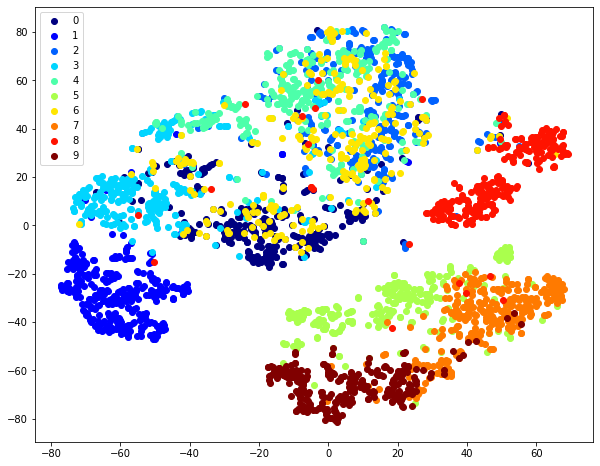

In [20]:
# display results

x_plot = tsne_results[:,0]
y_plot = tsne_results[:,1]

# https://stackoverflow.com/questions/42056713/matplotlib-scatterplot-with-legend
unique = list(set(labels_sel))
print(unique)
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [x_plot[j] for j  in range(len(x_plot)) if labels_sel[j] == u]
    yi = [y_plot[j] for j  in range(len(y_plot)) if labels_sel[j] == u]
    plt.scatter(xi, yi, color=colors[i], label=str(u))
plt.legend()

# plt.savefig('vis_trad_40epoch.jpg',dpi=200) # this


# plt.savefig('vis_trad_1chann_15epoch.jpg',dpi=200)
# plt.savefig('vis_sift_1chann_15epoch.jpg',dpi=200)
# plt.savefig('vis_trad_1chann_40epoch.jpg',dpi=200)
# plt.savefig('vis_sift_1chann_40epoch.jpg',dpi=200)
# plt.savefig('vis_trad_40epoch.jpg',dpi=200)
# plt.savefig('vis_trad_1chann_100complexity_40epoch.jpg',dpi=200)
# plt.savefig('vis_sift_1chann_100complexity_40epoch.jpg',dpi=200)
# plt.savefig('vis_trad_3chann_40epoch.jpg',dpi=200)
# plt.savefig('vis_trad_3chann_100complexity_40epoch.jpg',dpi=200)

# plt.savefig('tmp_vis_trad_1chann_15comp_1000iter_40epoch.jpg',dpi=200)
# plt.savefig('tmp_vis_trad_3chann_15comp_1000iter_40epoch.jpg',dpi=200)
# plt.savefig('tmp_vis_sift_1chann_15comp_1000iter_40epoch.jpg',dpi=200)
# plt.savefig('tmp_vis_sift_3chann_15comp_1000iter_40epoch.jpg',dpi=200)

## Notes

In [21]:
# # notes on running sift
# from pytorch_sift import SIFTNet

# SIFT = SIFTNet(patch_size = patch_size)
# SIFT.eval()

# # It takes n_patches x 1 x patch_size x patch_size input == standard pytorch batch format
# patches = np.ndarray((1, 1, patch_size, patch_size), dtype=np.float32)
# patches[0,0,:,:] = patch # set first (only) patch

# t = time.time()
# with torch.no_grad():
#     torch_patches = torch.from_numpy(patches)
#     print('torch_patches.shape',torch_patches.shape)
#     res = SIFT(torch_patches)
#     sift = np.round(512. * res.data.cpu().numpy()).astype(np.int32)
# print ('time', time.time() - t)
# print('sift.shape',sift.shape)
# print (sift)   



# SIFT = SIFT.cuda()
# with torch.no_grad():
#     torch_patches = torch.from_numpy(patches).cuda()
#     res = SIFT(torch_patches)
#     sift = np.round(512. * res.data.cpu().numpy()).astype(np.int32)
# print (sift)   



In [22]:
# final notes

# results:
# ran 64 features for traditional - vis dont change much
# way too much for the RAM for sift
# 64 features, > 1 epoch exceeds RAM for ideal case, both locally and on google colab
# biggest num features to run succsessfully is 3
# results for trad and sift for 1 faeture map
# sift a lot worse, may with more computational power it would be worth it

# though, although accuracy is bad, vis shows that SIFT offers some (spatial) cohesion between the different classes
# particulary in 1-channel case for classes 1 and 8